# Testing basic logistic regression model performance, baseline

In [8]:
import sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import json
import glob
import h5py
import time

np.random.seed(55)

# Set params

In [9]:
hdf_path = './all_prepped_data.h5'

In [10]:
all_cols = ['precip', 'temp', 'vpd', 'acres', 'winddevyr', 'meanwetfrq', 'cluster',
       'healthy', 'farmed', 'hydromod', 'fttoroad', 'sthick2013', 'lcf13',
       'lcf11', 'lcf14', 'lcf15', 'lcf2', 'lcf7', 'lcf6', 'lcf1', 'lcf12',
       'lcf9', 'lcf16', 'lcf8', 'lcf10', 'lcf3']

In [11]:
# Column selection
select_cols = ['precip', 'temp', 'vpd', 'acres',
                'cluster','healthy', 'farmed', 'hydromod',
               'fttoroad', 'meanwetfrq', 'sthick2013']#, #'winddevyr', 
#                'lcf13','lcf11', 'lcf14', 'lcf15', 'lcf2', 'lcf7', 'lcf6', 'lcf1', 
#                'lcf12', 'lcf9', 'lcf16', 'lcf8', 'lcf10', 'lcf3']
which_cols_from_hdf = np.isin(all_cols, select_cols)


In [12]:
years = np.repeat(np.arange(-1,1+2/34, 2/34), 12)[2:]
months = np.tile(np.arange(-1,1+2/11, 2/11), 35)[2:]

In [13]:
lstm_input_size = len(select_cols)

f = h5py.File(hdf_path, 'r')

# Get some params for reshaping
n_playas, train_seq_len = f['train_num'].shape[:2]
val_seq_len = f['val_num'].shape[1]
test_seq_len = f['test_num'].shape[1]

# Load data and run scaler simultaneously, requires some reshaping to 2d and back to 3d
scaler = StandardScaler()
train_val_num = np.concatenate([
    scaler.fit_transform(
    f['train_num'][()][:,:,which_cols_from_hdf].reshape(
        [-1, lstm_input_size])
    ).astype(np.float32),
    scaler.transform(
    f['val_num'][()][:,:,which_cols_from_hdf].reshape(
        [-1, lstm_input_size])
    ).astype(np.float32)
], axis=0)
train_val_y = np.concatenate([f['train_y'][()].flatten().astype(np.byte),
                             f['val_y'][()].flatten().astype(np.byte)])


In [14]:
train_val_num = np.concatenate([train_val_num,
    np.vstack([np.tile(years[:-48], n_playas), np.tile(months[:-48], n_playas)]).T], axis=1).astype(np.float32)
        

In [15]:
reg = LogisticRegression().fit(train_val_num, train_val_y)

In [16]:
test_num = scaler.transform(
    f['test_num'][()][:,:,which_cols_from_hdf].reshape(
        [-1, lstm_input_size])
    ).astype(np.float32)
test_num = np.concatenate([test_num,
                           np.vstack([np.tile(years[-48:], n_playas), np.tile(months[-48:], n_playas)]).T]
                          ,axis=1).astype(np.float32)
test_y = f['test_y'][()].flatten().astype(np.byte)
pred_test = reg.predict_proba(test_num)[:,1]


In [17]:
binary_cutoff=0.1
print('Accuracy:', accuracy_score(test_y, pred_test>binary_cutoff))
print('Precision:', precision_score(test_y, pred_test>binary_cutoff))
print('Recall:', recall_score(test_y, pred_test>binary_cutoff))
print('F1:',f1_score(test_y, pred_test>binary_cutoff))
print('Loss:', log_loss(test_y, pred_test))

Accuracy: 0.9425146373826225
Precision: 0.3197562055301828
Recall: 0.4505149307087333
F1: 0.3740369799691834
Loss: 0.11958232170881168


In [18]:
test_num[:,-2:]

array([[ 0.8235294, -1.       ],
       [ 0.8235294, -0.8181818],
       [ 0.8235294, -0.6363636],
       ...,
       [ 1.       ,  0.6363636],
       [ 1.       ,  0.8181818],
       [ 1.       ,  1.       ]], dtype=float32)

AUC:  0.8873745940147967


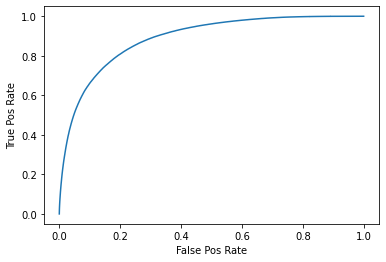

In [19]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_y, pred_test, pos_label=1)

print('AUC: ', sklearn.metrics.auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate')
plt.show()

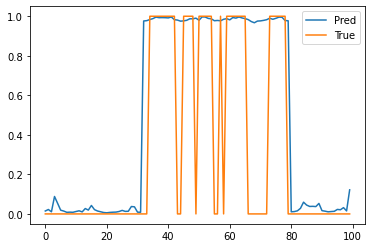

In [20]:
window = [467200, 467300]
pd.DataFrame({'Pred':pred_test[window[0]:window[1]], 'True':test_y[window[0]:window[1]]}).plot()